In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

data = pd.read_csv('BankNote_Authentication.csv') 

In [ ]:
data.head()
# data.describe()

,variance,skewness,curtosis,entropy,class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


In [ ]:
data = np.array(data)
m, n = data.shape
print(f'Dataset has {m} rows and {n} columns')
np.random.shuffle(data)

data_train = data[0:1000].T
Y_train = data_train[-1].astype(int)
X_train = data_train[0:n-1]

Dataset has 1372 rows and 5 columns


In [ ]:
m_train, n_train = X_train.shape
for i in range(m_train):
  X_train[i-1,:] = X_train[i-1,:] / (np.abs(X_train[i-1,:]).max())


In [ ]:
data_test = data[1000:m].T
Y_test = data_test[-1].astype(int)
X_test = data_test[0:n-1]

m_test, n_test = X_test.shape
for i in range(m_test):
  X_test[i-1,:] = X_test[i-1,:] / (np.abs(X_test[i-1,:]).max())

In [ ]:
def init_params():
    W1 = np.random.rand(10, n-1) - 0.5
    b1 = np.random.rand(10, 1) - 0.5
    W2 = np.random.rand(2, 10) - 0.5
    b2 = np.random.rand(2, 1) - 0.5
    
    k0 = np.random.rand(1,1)
    k1 = np.random.rand(1,1)
    return W1, b1, W2, b2, k0, k1

# Activation function for hidden layer
def activation_fn(Z, k0, k1): 
    return k0 + k1*Z

# Derivative of activation function for hidden layer
def activation_fn_deriv(Z, k0, k1):
    return k1

# Activation function for output layer
def softmax(Z): 
    A = np.exp(Z) / sum(np.exp(Z))
    return A

def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, int(Y.max()) + 1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y
    
def forward_prop(W1, b1, W2, b2, k0, k1, X):
    Z1 = W1.dot(X) + b1
    A1 = activation_fn(Z1, k0, k1)
    Z2 = W2.dot(A1) + b2
    A2 = softmax(Z2)
    return Z1, A1, Z2, A2

def backward_prop(Z1, A1, Z2, A2, W1, W2, k0, k1, X, Y):
    one_hot_Y = one_hot(Y)
    dZ2 = A2 - one_hot_Y

    dW2 = 1 / m * dZ2.dot(A1.T)
    db2 = 1 / m * np.sum(dZ2)
    dZ1 = W2.T.dot(dZ2) * activation_fn_deriv(Z1, k0, k1)
    dW1 = 1 / m * dZ1.dot(X.T)
    db1 = 1 / m * np.sum(dZ1)
    
    da1 = W2.T.dot(dZ2)
    dk0 = 1 / m * np.sum(da1)
    temp = np.multiply(da1,Z1)
    dk1 = np.mean(temp)
    return dW1, db1, dW2, db2, dk0, dk1

def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, k0, k1, dk0, dk1, alpha):
    W1 = W1 - alpha * dW1
    b1 = b1 - alpha * db1    
    W2 = W2 - alpha * dW2  
    b2 = b2 - alpha * db2
    k0 = k0 - alpha * dk0
    k1 = k1 - alpha * dk1
    return W1, b1, W2, b2, k0, k1

In [ ]:
def get_predictions(A2):
    return np.argmax(A2, 0)

def get_accuracy(predictions, Y):
    #print(predictions, Y)
    return np.sum(predictions == Y) / Y.size

In [ ]:
def cross_entropy(Y, A2, p):
    row, col = np.shape(A2)
    loss_CE = list()
    for i in range(col):
        pos = np.where(p[:,col-1]==1)
        loss = - p[pos,col-1]*np.log(softmax(A2[:,col-1])[pos])
        loss_CE.append(loss)
    return np.mean(loss_CE)

def gradient_descent(X, Y, X_test, Y_test, alpha, iterations):
    W1, b1, W2, b2, k0, k1 = init_params()
    k0_list = list()
    k1_list = list()
    loss_entropy_train = list()
    loss_entropy_test = list()
    epochs = list()
    
    for i in range(iterations):
        Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, k0, k1, X)
        dW1, db1, dW2, db2, dk0, dk1 = backward_prop(Z1, A1, Z2, A2, W1, W2, k0, k1, X, Y)
        W1, b1, W2, b2, k0, k1 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, k0, k1, dk0, dk1, alpha)
        
        epochs.append(i)
        k0_list.append(k0)
        k1_list.append(k1)
        
        true_label = one_hot(Y)
        loss_entropy_train.append(cross_entropy(Y, A2, true_label))
        
        Z1_test, A1_test, Z2_test, A2_test = forward_prop(W1, b1, W2, b2, k0, k1, X_test)
        true_label_test = one_hot(Y_test)
        loss_entropy_test.append(cross_entropy(Y_test, A2_test, true_label_test))
        
        if i % 100 == 0:            
            print("Iteration: ", i)
            predictions = get_predictions(A2)
            print(get_accuracy(predictions, Y))
            print("Loss (train): {:.3g} nats".format(loss_entropy_train[i-1]))
            print("Loss (test): {:.3g} nats".format(loss_entropy_test[i-1]))
    return W1, b1, W2, b2, k0, k1, k0_list, k1_list, epochs, loss_entropy_train, loss_entropy_test

In [ ]:
W1, b1, W2, b2, k0, k1, k0_list, k1_list, epochs, loss_entropy_train, loss_entropy_test = gradient_descent(X_train, Y_train, X_test, Y_test, 0.10, 1000) # Learning rate alpha = 0.1, total epochs = 1000

Iteration:  0
0.539
Loss (train): 0.554 nats
Loss (test): 0.873 nats
Iteration:  100
0.671
Loss (train): 0.639 nats
Loss (test): 0.709 nats
Iteration:  200
0.812
Loss (train): 0.56 nats
Loss (test): 0.66 nats
Iteration:  300
0.884
Loss (train): 0.398 nats
Loss (test): 0.535 nats
Iteration:  400
0.906
Loss (train): 0.339 nats
Loss (test): 0.44 nats
Iteration:  500
0.941
Loss (train): 0.324 nats
Loss (test): 0.389 nats
Iteration:  600
0.956
Loss (train): 0.318 nats
Loss (test): 0.36 nats
Iteration:  700
0.967
Loss (train): 0.315 nats
Loss (test): 0.343 nats
Iteration:  800
0.968
Loss (train): 0.314 nats
Loss (test): 0.333 nats
Iteration:  900
0.975
Loss (train): 0.314 nats
Loss (test): 0.327 nats


In [ ]:
print(f'The final values of parameters: k_0 = {k0}, k_1 = {k1}')

The final values of parameters: k_0 = [[0.0441651]], k_1 = [[1.3334264]]


In [ ]:
def make_predictions(X, W1, b1, W2, b2, k0, k1):
    _, _, _, A2 = forward_prop(W1, b1, W2, b2, k0, k1, X)
    predictions = get_predictions(A2)
    return predictions

In [ ]:
# Train data accuracy
train_data_predictions = make_predictions(X_train, W1, b1, W2, b2, k0, k1)
get_accuracy(train_data_predictions, Y_train)

0.981

In [ ]:
# Test data accuracy
test_data_predictions = make_predictions(X_test, W1, b1, W2, b2, k0, k1)
get_accuracy(test_data_predictions, Y_test)

0.989247311827957

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

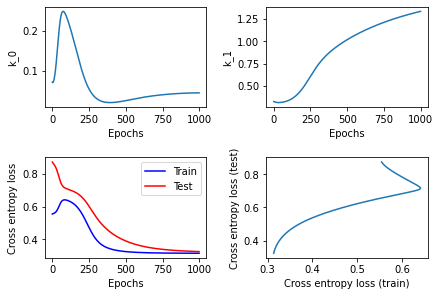

In [ ]:
fig, axs = plt.subplots(2,2,constrained_layout=True)
axs[0,0].plot(epochs, np.squeeze(k0_list))
axs[0,0].set(xlabel = 'Epochs', ylabel = 'k_0')
axs[0,1].plot(epochs, np.squeeze(k1_list))
axs[0,1].set(xlabel = 'Epochs', ylabel = 'k_1')
axs[1,0].plot(epochs,loss_entropy_train,'-b',label = 'Train')
axs[1,0].plot(epochs,loss_entropy_test,'-r',label = 'Test')
axs[1,0].legend()
axs[1,0].set(xlabel = 'Epochs', ylabel = 'Cross entropy loss')
axs[1,1].plot(loss_entropy_train,loss_entropy_test)
axs[1,1].set(xlabel = 'Cross entropy loss (train)', ylabel = 'Cross entropy loss (test)')

from google.colab import files
plt.savefig('banknote.jpg')
files.download('banknote.jpg')

In [ ]:
from sklearn.metrics import f1_score
f1 = f1_score(Y_test, test_data_predictions,average = 'weighted')
print(f'F1-Score is: {f1}')

F1-Score is: 0.9892589363557106
